# INSURANCE COST PREDICTION
### A supervised learning model that can predict the cost of premium for health insurance.

# Importing all the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV , RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Loading the dataset into the dataframe

In [2]:
data = pd.read_csv("Insurance Cost Prediction.csv")

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Total no.of rows and columns

In [4]:
data.shape

(5352, 7)

# Checking the types of data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5352 entries, 0 to 5351
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       5352 non-null   int64  
 1   sex       5352 non-null   object 
 2   bmi       5352 non-null   float64
 3   children  5352 non-null   int64  
 4   smoker    5352 non-null   object 
 5   region    5352 non-null   object 
 6   charges   5352 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 292.8+ KB


# Checking for duplicates

In [6]:
data.duplicated().sum()

4015

#### Duplicates are not removed as the dataset is small and model needs more data.

# Checking for missing values

In [7]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There are no missing values.

# Finding the unique values of each column

In [8]:
print("Age: ", data.age.unique())
print("Sex: ", data.sex.unique())
print("Children: ", data.children.unique())
print("Smoker: ", data.smoker.unique())
print("region: ", data.region.unique())

Age:  [19 18 28 33 32 31 46 37 60 25 62 23 56 27 52 30 34 59 63 55 22 26 35 24
 41 38 36 21 48 40 58 53 43 64 20 61 44 57 29 45 54 49 47 51 42 50 39]
Sex:  ['female' 'male']
Children:  [0 1 3 2 5 4]
Smoker:  ['yes' 'no']
region:  ['southwest' 'southeast' 'northwest' 'northeast']


# Converting categorical data to numerical

In [9]:
enc = LabelEncoder()

In [10]:
data.sex = enc.fit_transform(data.sex) # Female 0 and Male 1
data.smoker = enc.fit_transform(data.smoker) # No 0 and Yes 1
data.region = enc.fit_transform(data.region) # Northeast 0, Northwest 1, Southeast 2, Southwest 3

In [11]:
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
5,31,0,25.740,0,0,2,3756.62160
6,46,0,33.440,1,0,2,8240.58960
7,37,0,27.740,3,0,1,7281.50560
8,37,1,29.830,2,0,0,6406.41070
9,60,0,25.840,0,0,1,28923.13692


# Statistical information describe

In [12]:
data.describe()

,age,sex,bmi,children,smoker,region,charges
count,5352.000000,5352.000000,5352.000000,5352.000000,5352.000000,5352.000000,5352.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695,13270.422265
std,14.046021,0.500019,6.096477,1.205155,0.403581,1.104575,12106.616065
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.290000,0.000000,0.000000,1.000000,4738.268200
50%,39.000000,1.000000,30.400000,1.000000,0.000000,2.000000,9382.033000
75%,51.000000,1.000000,34.700000,2.000000,0.000000,2.000000,16657.717450
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


# Finding the outliers in numerical data

In [13]:
# Function to identify the outliers
def findoutliers(column):
    outliers=[]
    Q1=column.quantile(.25)
    Q3=column.quantile(.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in column:
        if out1>upper_limit or out1 <lower_limit:
            outliers.append(out1)
            
    return np.array(outliers)  

In [14]:
print(len(findoutliers(data.age))) # Number of rows having outlier in age

0


In [15]:
print(len(findoutliers(data.bmi))) # Number of rows having outlier in bmi

36


In [16]:
print(len(findoutliers(data.children))) # Number of rows having outlier in children

0


<AxesSubplot:xlabel='bmi'>

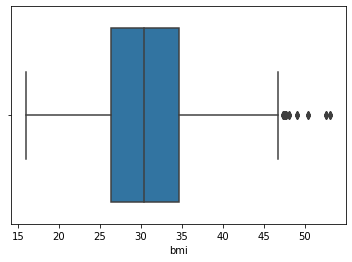

In [17]:
sn.boxplot(data.bmi) # Visualising bmi- outliers

#### Outliers are not removed as models like decision tree are not sensitive to outliers.

# Visualising numerical data

(array([888., 560., 436., 512., 408., 548., 576., 456., 512., 456.]),
 array([18. , 22.6, 27.2, 31.8, 36.4, 41. , 45.6, 50.2, 54.8, 59.4, 64. ]),
 <BarContainer object of 10 artists>)

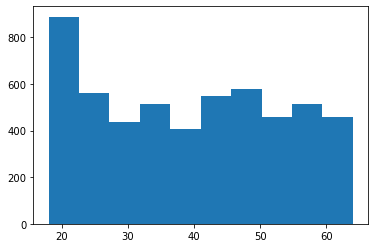

In [18]:
plt.hist(data.age) # Continuous data

(array([ 120.,  508.,  936., 1276., 1152.,  780.,  384.,  128.,   56.,
          12.]),
 array([15.96 , 19.677, 23.394, 27.111, 30.828, 34.545, 38.262, 41.979,
        45.696, 49.413, 53.13 ]),
 <BarContainer object of 10 artists>)

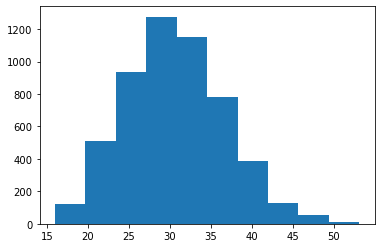

In [19]:
plt.hist(data.bmi) # Continuous data

(array([2296.,    0., 1296.,    0.,  960.,    0.,  628.,    0.,  100.,
          72.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

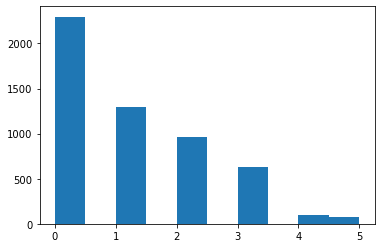

In [20]:
plt.hist(data.children) # Discrete data

# Analysing and visualising categorical data

In [21]:
data.sex.value_counts() # Nominal data

1    2704
0    2648
Name: sex, dtype: int64

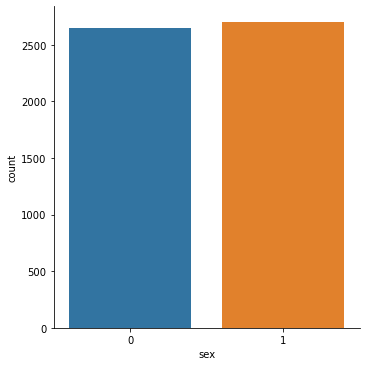

In [22]:
sn.factorplot('sex',data=data,kind='count')

In [23]:
data.smoker.value_counts() # Nominal data

0    4256
1    1096
Name: smoker, dtype: int64

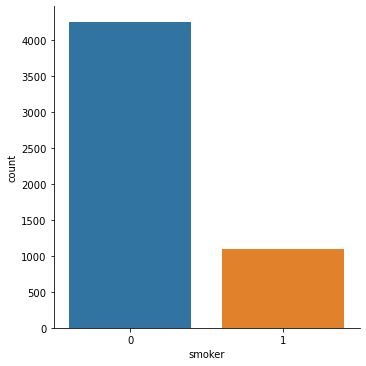

In [24]:
sn.factorplot('smoker',data=data,kind='count')

In [25]:
data.region.value_counts() # Norminal data

2    1456
1    1300
3    1300
0    1296
Name: region, dtype: int64

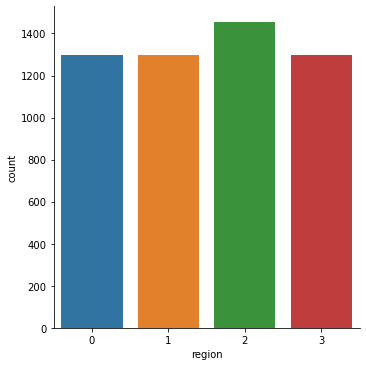

In [26]:
sn.factorplot('region',data=data,kind='count')

# Checking the normality of data
###### AGE

In [27]:
print("Skewness of age: ", stats.skew(data.age))
print("Kurtosis of age: ", stats.kurtosis(data.age))

Skewness of age:  0.05561008307259913
Kurtosis of age:  -1.2449206804584227


Age is not normaly distributed as the kurtosis of age is greater than -1.

###### SEX

In [28]:
print("Skewness of sex: ", stats.skew(data.sex))
print("Kurtosis of sex: ", stats.kurtosis(data.sex))

Skewness of sex:  -0.0209279020013669
Kurtosis of sex:  -1.9995620229178213


Sex is not normaly distributed as the kurtosis of sex is greater than -1.

###### BMI

In [29]:
print("Skewness of bmi: ", stats.skew(data.bmi))
print("Kurtosis of bmi: ", stats.kurtosis(data.bmi))

Skewness of bmi:  0.28372857291709386
Kurtosis of bmi:  -0.05502310583700032


BMI is normaly distributed.

###### CHILDREN

In [30]:
print("Skewness of children: ", stats.skew(data.children))
print("Kurtosis of children: ", stats.kurtosis(data.children))

Skewness of children:  0.9373281163874424
Kurtosis of children:  0.1972174268623732


Children is normaly distributed.

###### SMOKER

In [31]:
print("Skewness of smoker: ", stats.skew(data.smoker))
print("Kurtosis of smoker: ", stats.kurtosis(data.smoker))

Skewness of smoker:  1.4631235340273212
Kurtosis of smoker:  0.14073047582459797


Smoker is nomaly distributed.

###### REGION

In [32]:
print("Skewness of region: ", stats.skew(data.region))
print("Kurtosis of region: ", stats.kurtosis(data.region))

Skewness of region:  -0.038057781143998944
Kurtosis of region:  -1.327226577401974


Region is not normaly distributed as the kurtosis of region is greater than -1.

# Checking the correlation with dependent variable

In [33]:
data.corrwith(data.charges)

age         0.299008
sex         0.057292
bmi         0.198341
children    0.067998
smoker      0.787251
region     -0.006208
charges     1.000000
dtype: float64

In [34]:
data.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


# Heatmap

<AxesSubplot:>

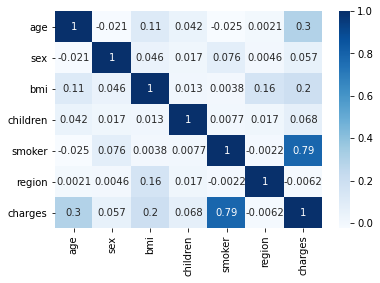

In [35]:
corr = data.corr()
sn.heatmap(corr, cmap = 'Blues', annot= True)

- Age has weak positive correlation
- Sex has weak positive correlation 
- BMI has weak positive correlation
- Children has weak positive correlation
- Smoker has strong positive correlation
- Region has very weak positive correlation (almost no correlation)

# Feature scaling (using min-max scaler)

In [36]:
scaler = MinMaxScaler()
data[['age','bmi','sex','children','smoker']]=scaler.fit_transform(data[['age','bmi','sex','children','smoker']])

In [37]:
data.head(10)

,age,sex,bmi,children,smoker,region,charges
0,0.021739,0.0,0.321227,0.0,1.0,3,16884.92400
1,0.000000,1.0,0.479150,0.2,0.0,2,1725.55230
2,0.217391,1.0,0.458434,0.6,0.0,2,4449.46200
3,0.326087,1.0,0.181464,0.0,0.0,1,21984.47061
4,0.304348,1.0,0.347592,0.0,0.0,1,3866.85520
5,0.282609,0.0,0.263115,0.0,0.0,2,3756.62160
6,0.608696,0.0,0.470272,0.2,0.0,2,8240.58960
7,0.413043,0.0,0.316922,0.6,0.0,1,7281.50560
8,0.413043,1.0,0.373150,0.4,0.0,0,6406.41070
9,0.913043,0.0,0.265806,0.0,0.0,1,28923.13692


# Defining independent and dependent

In [38]:
X = data.iloc[:,:-2]
y = data.charges

## Region Column has been removed as it has low Correlation

In [39]:
X

,age,sex,bmi,children,smoker
0,0.021739,0.0,0.321227,0.0,1.0
1,0.000000,1.0,0.479150,0.2,0.0
2,0.217391,1.0,0.458434,0.6,0.0
3,0.326087,1.0,0.181464,0.0,0.0
4,0.304348,1.0,0.347592,0.0,0.0
...,...,...,...,...,...
5347,0.695652,1.0,0.403820,0.6,0.0
5348,0.000000,0.0,0.429379,0.0,0.0
5349,0.000000,0.0,0.562012,0.0,0.0
5350,0.065217,0.0,0.264730,0.0,0.0


In [40]:
y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
5347    10600.54830
5348     2205.98080
5349     1629.83350
5350     2007.94500
5351    29141.36030
Name: charges, Length: 5352, dtype: float64

# Spliting the data into training and testing data

In [41]:
x_train, x_test, y_train, y_test = train_test_split( X, y, train_size = 0.6, random_state = 20)

# Linear Regression

In [42]:
model_lr = LinearRegression()

# Training the model

In [43]:
model_lr.fit(x_train,y_train)

LinearRegression()

# Testing the model

In [44]:
y_predict_lr = model_lr.predict(x_test)

In [45]:
r2_lr = r2_score(y_test,y_predict_lr)
r2_lr

0.7468978240254863

In [46]:
mse_lr = mean_squared_error(y_test,y_predict_lr)
mse_lr

36943495.38813208

# Ridge Regression

In [47]:
model_rr = Ridge()

# Training the model

In [48]:
model_rr.fit(x_train,y_train)

Ridge()

# Testing the model

In [49]:
y_predict_rr = model_rr.predict(x_test)

In [50]:
r2_rr = r2_score(y_test,y_predict_rr)
r2_rr

0.746844874988402

In [51]:
mse_rr = mean_squared_error(y_test,y_predict_rr)
mse_rr

36951223.97639805

# Lasso Regression

In [52]:
model_ll = Lasso()

# Training the model

In [53]:
model_ll.fit(x_train,y_train)

Lasso()

# Testing the model

In [54]:
y_predict_ll = model_ll.predict(x_test)

In [55]:
r2_ll = r2_score(y_test,y_predict_ll)
r2_ll

0.7468863889107014

In [56]:
mse_ll = mean_squared_error(y_test,y_predict_ll)
mse_ll

36945164.48919252

# SVM

In [57]:
model_sv = SVR(kernel='rbf')

# Training the model

In [58]:
model_sv.fit(x_train,y_train)

SVR()

# Testing the model

In [59]:
y_predict_sv = model_sv.predict(x_test)

In [60]:
r2_sv = r2_score(y_test,y_predict_sv)
r2_sv

-0.07379434019340603

In [61]:
mse_sv = mean_squared_error(y_test,y_predict_sv)
mse_sv

156733999.2317253

# Decision Tree

In [62]:
model_dt = DecisionTreeRegressor(random_state=0)

# Training the model

In [63]:
model_dt.fit(x_train,y_train)

DecisionTreeRegressor(random_state=0)

# Testing the model

In [64]:
y_predict_dt = model_dt.predict(x_test)

In [65]:
r2_dt = r2_score(y_test,y_predict_dt)
r2_dt

0.97563464163422

In [66]:
Adj_r2 = 1 - (1-r2_dt) * (len(y)-1)/(len(y)-X.shape[1]-1)
Adj_r2

0.9756118532332044

In [67]:
mse_dt = mean_squared_error(y_test,y_predict_dt)
mse_dt

3556435.2655230444

# Random Forest

In [68]:
model_rf = RandomForestRegressor()

# Training the model

In [69]:
model_rf.fit(x_train,y_train)

RandomForestRegressor()

# Testing the model

In [70]:
y_predict_rf = model_rf.predict(x_test)

In [71]:
r2_rf = r2_score(y_test,y_predict_rf)
r2_rf

0.9696445115825983

In [72]:
Adj_r2 = 1 - (1-r2_rf) * (len(y)-1)/(len(y)-X.shape[1]-1)
Adj_r2

0.9696161207404571

In [73]:
mse_rf = mean_squared_error(y_test,y_predict_rf)
mse_rf

4430771.256844905

# Model Evaluation

In [74]:
MSE = [mse_lr,mse_rr,mse_ll,mse_sv,mse_dt,mse_rf]
R2_Score = [r2_lr,r2_rr,r2_ll,r2_sv,r2_dt,r2_rf]
Models = ['Linear Regression', ' Ridge Regression' , ' Lasso Regression', 'Support Vector Machine',
          'Decision Tree', 'Random Forest']

# Mean Squared Error Comparison Chart

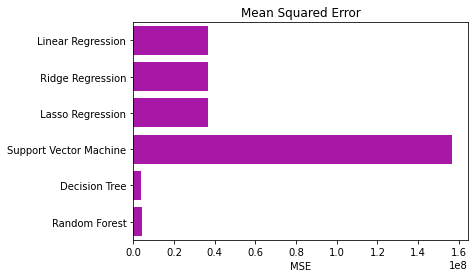

In [75]:
sn.barplot(MSE, Models, color="m")
plt.xlabel('MSE')
plt.title('Mean Squared Error')
plt.show()

# R2 Score Comparison Chart

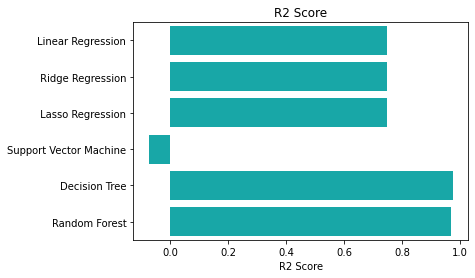

In [76]:
sn.barplot(R2_Score, Models, color="c")
plt.xlabel('R2 Score')
plt.title('R2 Score')
plt.show()

#### From the charts it can be seen that the Mean Squared Error is lowest for decision tree and the R2 Score is highest for decision tree. Therefore, we can conclude that decision tree is the best algorithm for this data. 

# Hyperparameter Tuning (using grid search)

In [77]:
parameters = {'max_depth':[10,30,50,70,90,110,150,200],
              'random_state': [0,1,10,14,20,27],
              'max_features':['int','float','auto','sqrt','log2','None']}

grid = GridSearchCV(model_dt,parameters,cv=5,verbose=1)
grid.fit(X,y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [10, 30, 50, 70, 90, 110, 150, 200],
                         'max_features': ['int', 'float', 'auto', 'sqrt',
                                          'log2', 'None'],
                         'random_state': [0, 1, 10, 14, 20, 27]},
             verbose=1)

In [78]:
grid.best_score_

0.9985634417325351

In [79]:
grid.best_params_

{'max_depth': 30, 'max_features': 'auto', 'random_state': 0}

# Hyperparameter Tuning (using randomized search)

In [101]:
parameters = {'max_depth':[25,30,35],
              'random_state':[0,1,2,3,4],
              'max_features':['int','float','sqrt','None','auto','log2']}
grid = RandomizedSearchCV(model_dt,parameters,cv=5)
grid.fit(X,y)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeRegressor(max_depth=35,
                                                   max_features='sqrt',
                                                   random_state=1),
                   param_distributions={'max_depth': [25, 30, 35],
                                        'max_features': ['int', 'float', 'sqrt',
                                                         'None'],
                                        'random_state': [0, 1, 2, 3, 4]})

In [102]:
grid.best_score_

0.9985634417325351

In [103]:
grid.best_params_

{'random_state': 1, 'max_features': 'sqrt', 'max_depth': 30}

# Training Decision Tree with best parameters

In [83]:
model_dt = DecisionTreeRegressor(max_depth=35,max_features='sqrt',random_state=1)
model_dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=35, max_features='sqrt', random_state=1)

# Testing Decision Tree with best parameters

In [84]:
y_predict_dt = model_dt.predict(x_test)

In [85]:
r2_dt = r2_score(y_test,y_predict_dt)
r2_dt

0.9840085608961938

In [86]:
Adj_r2 = 1 - (1-r2_dt) * (len(y)-1)/(len(y)-X.shape[1]-1)
Adj_r2

0.9839936044436088

#### Adjusted R2 score is less than the R2 score

# K-Fold cross-validation

In [87]:
scores =cross_val_score(model_dt,X,y,cv=5)

In [88]:
scores

array([0.99831954, 0.9983294 , 0.99833215, 0.99894158, 0.99889453])

In [89]:
scores.mean()

0.9985634417325351

In [90]:
scores.std() # Standard Deviation is less than 0.05

0.00028995554056619293

# Visualising the tree

In [91]:
from sklearn import tree

In [92]:
!pip install graphviz

In [93]:
import graphviz

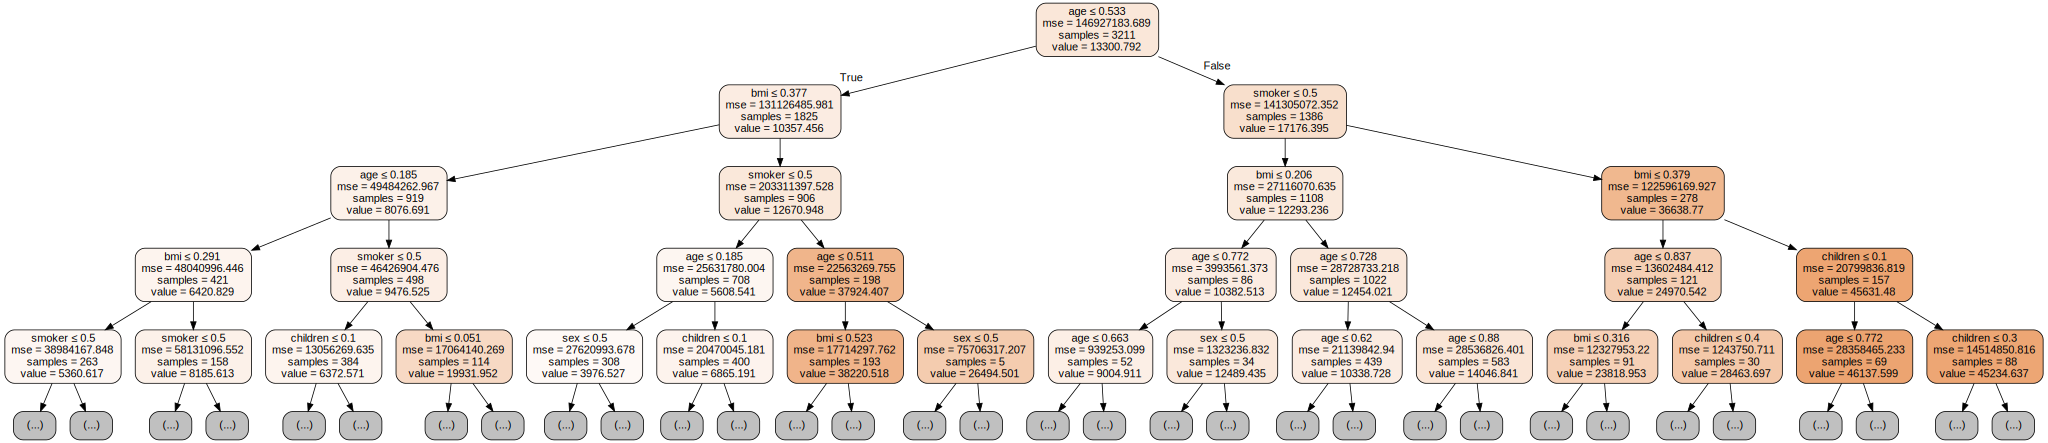

In [94]:
dot_data = tree.export_graphviz(model_dt, out_file=None, 
                      feature_names=['age','sex','bmi','children','smoker'],  
                      filled=True, rounded=True,  
                      special_characters=True,
                      max_depth=4)  
graph = graphviz.Source(dot_data)  
graph 

# Project Analysis

Machine learning algorithms can predict the cost of the premium for health insurance. The cost of the premium for health insurance varies from person to person. For example, a smoker is charged higher premium than a non-smoker. Companies calculate the premium for each person based on few factors like age, bmi, smoker etc. It is possible to predict the premium cost using machine learning algorithms. We can train a machine learning algorithm using the past data to predict the premium cost. 

The size of past data 5352 records. It contained 7 columns, out of which six of them was independent variable and one was dependent variable. The data was labeled so we can do supervised learning algorithms. As the dependent variable is continuous numerical value this is a regression problem. The data contains no missing values but it does contain outliers. 

However, some machine learning algorithms like decision tree and random forest are not sensitive to outliers, therefore we have not removed the outliers. The variables have good correlation except for regions. The variables like bmi, children and smoker are normally distributed but the others are not. Feature scaling using min-max scaler was done to give all features equal importance. Regions was removed as it had no correlation. Different ml algorithms were trained using the dataset and tested. 

Decision tree gave the best r2 score of 97.56% and adjusted r2 score of 97.56% as well.We trained the decision tree algorithm again with best parameters from randomised search. The r2 score increased to 98.401% and adjusted r2 score was 98.399%. The r2 score is greater than the adjusted r2 score. A visualisation of the tree was also done to have better interpretation of the algorithm.